In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

In [2]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

torch.set_default_dtype(torch.float32)

In [45]:
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

## Declare classes

In [4]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out
    
class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[10]):
        super().__init__(inp_size, layers)
        input_w_size = inp_size*layers[0]
        input_b_size = layers[0]

        hidden_w_size = layers[0]*10
        hidden_b_size = 10

        self.inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
        self.inp_bias = weights[input_w_size:input_w_size+input_b_size]

        self.output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
        self.output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]

    def forward(self, data):
        out = F.linear(data, self.inp_weights, self.inp_bias)
        out = self.relu(out)
        out = F.linear(out, self.output_weights, self.output_bias)
        return out
    
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

In [7]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20, layers=[64, 256], test_nodes=100):
        super().__init__()
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, layers[0])
        self.hidden1 = torch.nn.Linear(layers[0], layers[1])
        self.out = torch.nn.Linear(layers[1], self.out_size)
        
        self.relu = torch.nn.ReLU()
        self.template = np.zeros(inp_size)
        self.test_nodes = test_nodes
        self.test_mask = self._create_mask(test_nodes)
        
    def forward(self, data, mask=None):
        """ Get a hypernet prediction.
        
        Args:
            data - prediction input
            mask - either None or a torch.tensor((data.shape[0], data.shape[1])).
        """
        if self.training:
            if mask is None:
                masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(len(data))])
                tmp = np.array([self.template.copy() for _ in range(len(data))])
                for i, mask in enumerate(masks):
                    tmp[i, mask] = 1
                mask = torch.from_numpy(tmp).to(torch.float32).cuda()

            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).cuda()
            for i in range(len(data)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[i, mask[i].to(torch.bool)]
                res[i] = nn(masked_data)
            return res
        else:
            if mask is None:
                mask = self.test_mask

            nets = []
            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).cuda()
            for i in range(len(mask)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[:, mask[i].to(torch.bool)]
                res += nn(masked_data)
            res /= self.test_nodes
            return res

#     def forward(self, data, mask=None):
#         if mask is None:
#             mask = np.random.choice(len(template), self.mask_size, False)
#             tmp = self.template.copy()
#             tmp[mask] = 1
#             mask = torch.from_numpy(tmp).to(torch.float32).cuda()
        
#         weights = self.craft_network(mask)
#         nn = InsertableNet(weights, self.mask_size, layers=[self.node_hidden_size])
#         masked_data = data[:, mask.to(torch.bool)]
#         return nn(masked_data)
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32).cuda()
        return mask
    
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        out = self.hidden1(out)
        out = self.relu(out)
        out = self.out(out)
        return out

In [8]:
hypernet = Hypernetwork(mask_size=20, node_hidden_size=10).cuda()

In [10]:
hypernet.eval()
# print(hypernet(inputs).shape)
# print(hypernet.out_size)

Hypernetwork(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=320, bias=True)
  (relu): ReLU()
)

## Load data

In [11]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [12]:
batch_size = 32
test_batch_size = 1000

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)

## Craft model

In [13]:
def train_loop(hypernet, optimizer, epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        hypernet.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                experiment.log_metric("batch_accuracy", correct / total * 100)

                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        hypernet.eval()
        for i, data in enumerate(testloader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = hypernet(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss/i)
        print(f"Test acc: {correct/len(testset)*100}")
        experiment.log_metric("test_accuracy", correct/len(testset)*100)

In [14]:
criterion = torch.nn.CrossEntropyLoss()

### Verify the model on a preset mask

In [105]:
hypernet = Hypernetwork(mask_size=30, test_nodes=1, node_hidden_size=10).cuda()
hypernet = hypernet.train()

In [106]:
input_size = 784
mask_size = 30

np.random.seed(42)
template = np.zeros(input_size)
mask_idx = np.random.choice(len(template), mask_size, False)
template[mask_idx] = 1
mask = torch.from_numpy(template).to(torch.float32).cuda()
# mask = mask.unsqueeze(0).repeat(batch_size, 1)

In [107]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

In [108]:
experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
experiment.add_tag("fixed_mask")
experiment.log_parameter("test_nodes", 1)

train_loss = []
test_loss = []
for epoch in range(epochs): 
    total_loss = 0
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(tqdm(trainloader)):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = hypernet(inputs, mask.unsqueeze(0).repeat(len(inputs), 1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1)==labels).float().sum()
        total += outputs.shape[0]
        running_loss += loss.item()
        train_loss.append(loss.item())
        if i>0 and i % 100 == 0:
            total_loss += running_loss/100
            running_loss = 0.0
            correct = 0
            total=0

    total_loss = 0
    correct = 0
    for i, data in enumerate(testloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = hypernet(images, mask.unsqueeze(0).repeat(len(images), 1))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total_loss += criterion(outputs, labels).item()
        
    test_loss.append(total_loss)
    print(f"Test acc: {correct/len(testset)*100}, loss: {total_loss/i}")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/d5b06f80ed8349feb4fcef54cb5996ba
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [56] : (0.6758928894996643, 2.294724941253662)
COMET INFO:   Parameters:
COMET INFO:     test_nodes : 1
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (75.04 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environ

Test acc: 65.36999999999999, loss: 1.1659077008565266


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:48<00:00, 17.32it/s]


Test acc: 67.49000000000001, loss: 1.118842687871721


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.15it/s]


Test acc: 67.75, loss: 1.1152933571073744


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:49<00:00, 17.14it/s]


Test acc: 67.49000000000001, loss: 1.109749390019311


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:45<00:00, 17.73it/s]


Test acc: 68.5, loss: 1.0774634612931147


In [ ]:
plt.title("Train loss")
plt.plot(train_loss);
plt.show()
plt.title("Test loss")
plt.plot(test_loss);

### Bayesian hyperparam search

In [ ]:
config = {
    "algorithm": "bayes",
    "parameters": {
        "l1": {"type": "categorical", "values": ["64"]},
        "l2": {"type": "categorical", "values": ["256"]},
        "l3": {"type": "categorical", "values": ["256"]},
        "learning_rate2": {"type": "float", "min": 0.0001, "max": 0.1, "scalingType": "loguniform"},
        "batch_size": {"type": "categorical", "values": ["32", "64"]},
    },
    "spec": {
    "metric": "loss",
    "objective": "minimize",
    },
}

opt = Optimizer(config, api_key=os.environ.get("COMET_KEY"))
criterion = torch.nn.CrossEntropyLoss()

for experiment in opt.get_experiments(project_name="hypernetwork"):
    experiment.add_tag("optimization")

    batch_size = int(experiment.get_parameter("batch_size"))
    test_batch_size = 1000

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                             shuffle=False, num_workers=1)
    
    hypernet = Hypernetwork(mask_size=30, layers=[
            int(experiment.get_parameter("l1")), 
            int(experiment.get_parameter("l2")), 
            int(experiment.get_parameter("l3"))
    ]).cuda()
    
    
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
    train_loop(hypernet, optimizer, 10)
    
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=experiment.get_parameter("learning_rate2"))
    train_loop(hypernet, optimizer, 10)
    experiment.end()

COMET INFO: COMET_OPTIMIZER_ID=60479ac6ac4047ca8e0882a4d796ba17
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '60479ac6ac4047ca8e0882a4d796ba17', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '60479ac6ac4047ca8e0882a4d796ba17', 'parameters': {'batch_size': {'type': 'categorical', 'values': ['32', '64']}, 'l1': {'type': 'categorical', 'values': ['64']}, 'l2': {'type': 'categorical', 'values': ['256']}, 'l3': {'type': 'categorical', 'values': ['256']}, 'learning_rate2': {'max': 0.1, 'min': 0.0001, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 24414777470, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'tr

Test acc: 24.37


### Train the full model

In [56]:
batch_size = 32
test_batch_size = 1000

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)

hypernet = Hypernetwork(mask_size=30, layers=[64, 256], node_hidden_size=10, test_nodes=1).cuda()

In [57]:
experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
experiment.add_tag("training")
experiment.log_parameter("test_nodes", hypernet.test_nodes)

epochs = 10
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
train_loop(hypernet, optimizer, epochs)
# epochs = 50
# optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-5)
# train_loop(hypernet,optimizer, epochs)
experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/2738a792dce44f2d8447305b682b22a4

100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:46<00:00, 17.61it/s]


Test acc: 18.86


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:45<00:00, 17.73it/s]


Test acc: 22.040000000000003


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:48<00:00, 17.23it/s]


Test acc: 21.17


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:46<00:00, 17.62it/s]


Test acc: 21.32


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:45<00:00, 17.85it/s]


Test acc: 21.66


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:44<00:00, 17.98it/s]


Test acc: 22.09


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:49<00:00, 17.11it/s]


Test acc: 24.14


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:44<00:00, 17.86it/s]


Test acc: 21.17


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:51<00:00, 16.79it/s]


Test acc: 22.27


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:46<00:00, 17.65it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/2738a792dce44f2d8447305b682b22a4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_accuracy [180] : (12.561882019042969, 34.281246185302734)
COMET INFO:     loss [1875]          : (1.4349006414413452, 2.479302167892456)
COMET INFO:     test_accuracy [10]   : (18.86, 24.14)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (37.14 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     note

Test acc: 19.17


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


In [ ]:
def test_model(hypernet, verbose=False):
    correct = 0
    loss = 0
    hypernet.eval()
    for i, data in enumerate(testloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = hypernet(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss += criterion(outputs, labels).item()

    if verbose:
        print(f"Test acc: {correct/len(testset)*100:.2f}")
        print(f"Test loss: {total_loss/i}")
    return correct/len(testset)*100

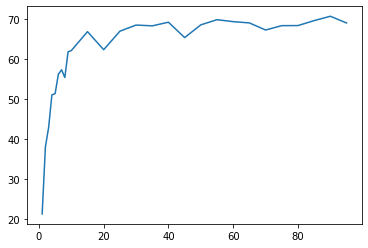

In [216]:
acc = []
nodes = []

for test_nodes in np.arange(1, 10):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
for test_nodes in np.arange(10, 100, 5):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
plt.plot(nodes, acc)